Loaded 400000 word vectors!

--- Trial 1 ---

--- Trial 2 ---

--- Trial 3 ---

--- Trial 4 ---

--- Trial 5 ---

--- Trial 6 ---

--- Trial 7 ---

--- Trial 8 ---

--- Trial 9 ---

--- Trial 10 ---

Average success rate over 10 trials: 58.8%


C:\Users\hhl222\AppData\Local\Temp\ipykernel_17308\3253233800.py:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(trajectories))


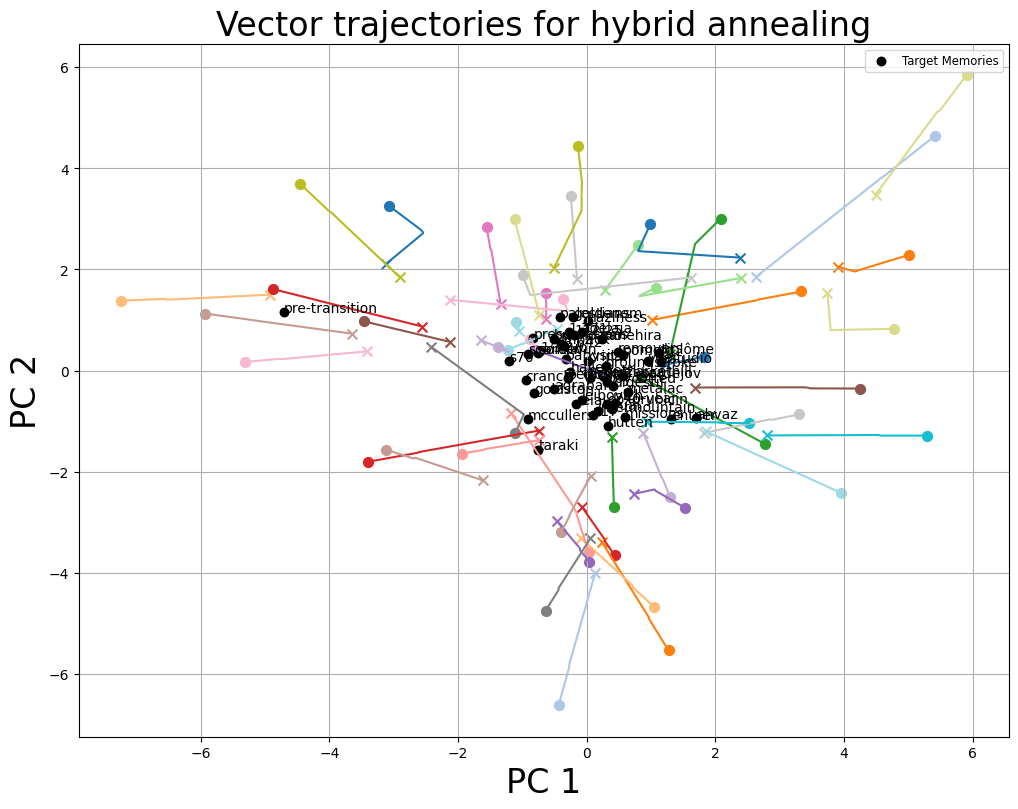

C:\Users\hhl222\AppData\Local\Temp\ipykernel_17308\3253233800.py:190: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


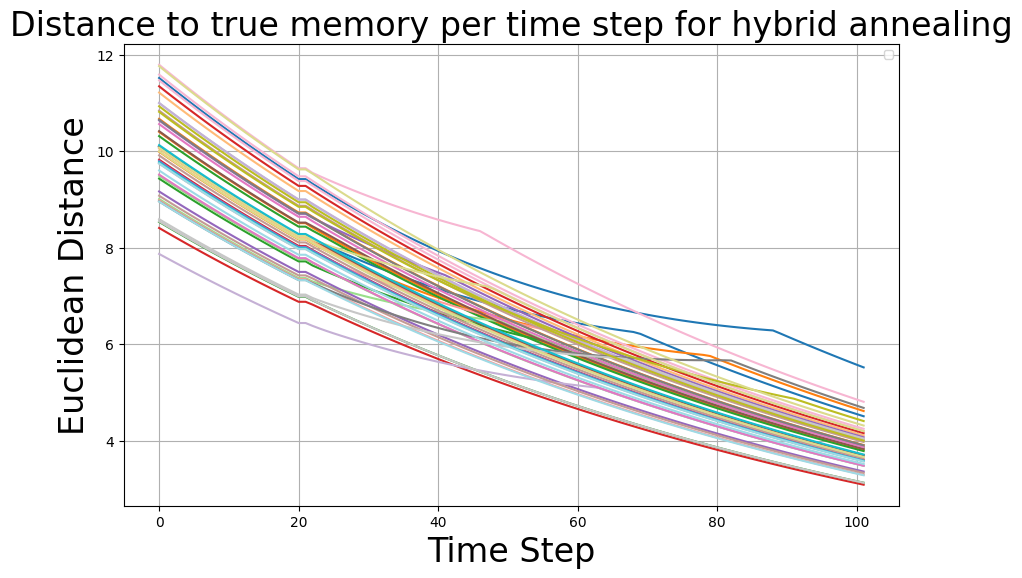

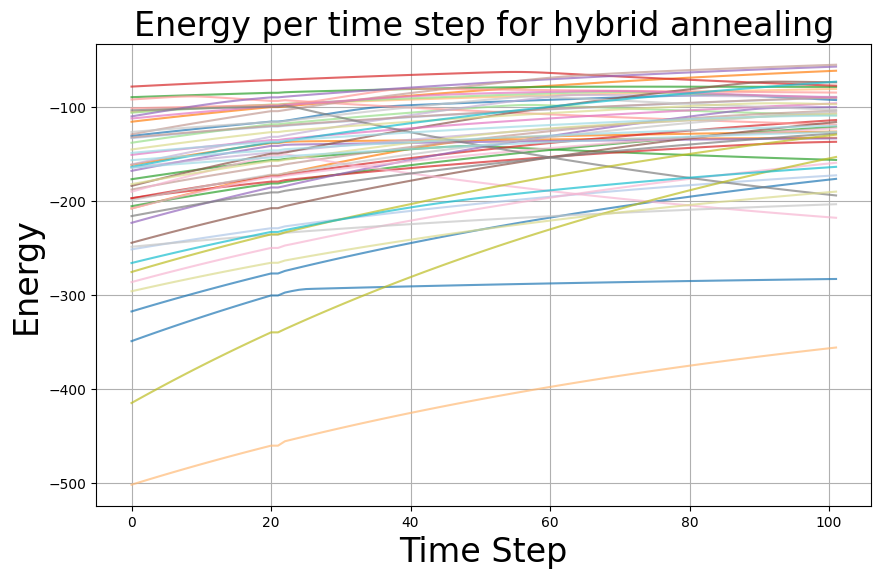

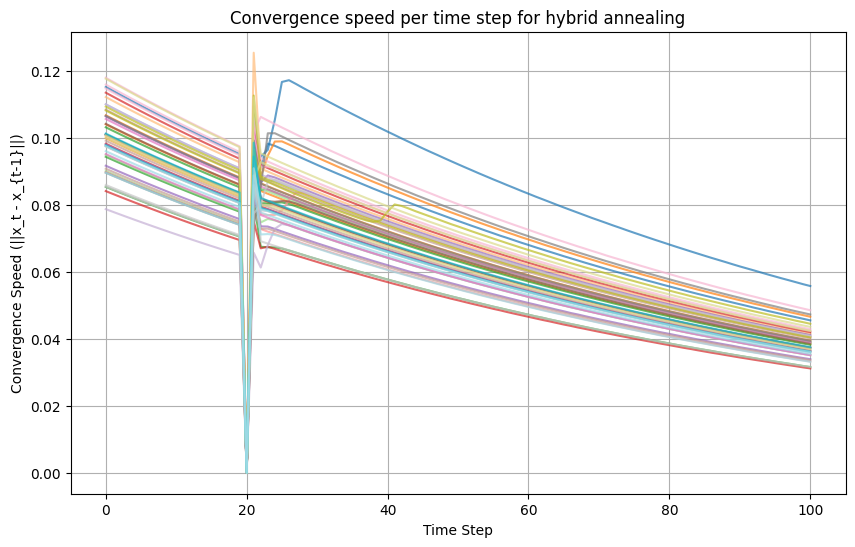

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.decomposition import PCA
import random
import matplotlib.cm as cm

# -------------------------------------------
# 1. Load GloVe Vectors
# -------------------------------------------

glove_path = 'C:\\Users\\hhl222\\Downloads\\glove.6B.50d.txt'

word_vectors = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        word_vectors[word] = vector

print(f"Loaded {len(word_vectors)} word vectors!")

# -------------------------------------------
# 2. Reverse Diffusion
# -------------------------------------------

def estimate_score(x, memory_vectors, sigma=0.1):
    distances = np.linalg.norm(memory_vectors - x, axis=1)
    closest_idx = np.argmin(distances)
    score = (memory_vectors[closest_idx] - x) / (sigma ** 2)
    return score

def reverse_diffusion(x_init, memory_vectors, sigma=0.1, dt=0.01, steps=20, tol=1e-3):
    x = x_init.copy()
    trajectory = [x.copy()]
    for step in range(steps):
        score = estimate_score(x, memory_vectors, sigma)
        x += sigma**2 * score * dt
        trajectory.append(x.copy())
        if np.linalg.norm(trajectory[-1] - trajectory[-2]) < tol:
            print(f"Reverse diffusion converged at step {step}")
            break
    return np.array(trajectory)

# -------------------------------------------
# 3. Hopfield Annealing with Euler-Maruyama Dynamics
# -------------------------------------------

def hopfield_annealing_until_converge(initial_x, memory_vectors, w, beta_max=80.0, dt=0.01,
                                      sigma_noise=1e-4, tol=1e-3, max_steps=80):
    N = memory_vectors.shape[1]
    x = initial_x.copy()
    trajectory = [x.copy()]

    for step in range(max_steps):
        beta = beta_max * (step / max_steps)
        logits = beta * (memory_vectors @ x) + beta * w
        p = softmax(logits)
        x_dot = memory_vectors.T @ p - x
        noise = sigma_noise * np.sqrt(dt) * np.random.randn(N)
        x_new = x + dt * x_dot + noise

        trajectory.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            print(f"Hopfield annealing converged at step {step} (beta={beta:.2f})")
            break

        x = x_new

    return np.array(trajectory)

# -------------------------------------------
# 4. Hybrid Experiment with Gaussian Noise
# -------------------------------------------

def hybrid_experiment_with_noisy_start(memory_vectors, start_index=0, dimension=50,
                                       sigma_diffusion=1, sigma_noise=1e-4,
                                       noise_level=1.5):
    base_vector = memory_vectors[start_index].copy()
    noisy_start = base_vector + noise_level * np.random.randn(dimension)
    diffusion_traj = reverse_diffusion(noisy_start, memory_vectors,
                                       sigma=sigma_diffusion, steps=20)
    w = np.zeros(dimension)
    hopfield_traj = hopfield_annealing_until_converge(diffusion_traj[-1], memory_vectors,
                                                      w=w, sigma_noise=sigma_noise)
    combined_traj = np.vstack((diffusion_traj, hopfield_traj))
    return combined_traj

# -------------------------------------------
# 5. Run Trials with new subset sampling inside each trial
# -------------------------------------------

num_trials = 10
success_rates = []
all_trials_trajectories = []
all_trials_distances = []
noise_level = 1.5
subset_size = 50

for trial in range(num_trials):
    print(f"\n--- Trial {trial+1} ---")

    # Sample new subset inside each trial
    all_words = list(word_vectors.keys())
    subset_words = random.sample(all_words, subset_size)
    Xi = np.stack([word_vectors[word] for word in subset_words])
    K = Xi.shape[0]
    dimension = Xi.shape[1]

    successes = 0
    all_trajectories = []
    euclidean_distances = []

    for start_idx in range(K):
        traj = hybrid_experiment_with_noisy_start(Xi, start_index=start_idx,
                                                  dimension=dimension,
                                                  noise_level=noise_level)
        all_trajectories.append(traj)

        distances = []
        for x in traj:
            dist = np.min(np.linalg.norm(Xi - x, axis=1))
            distances.append(dist)
        euclidean_distances.append(distances)

        final_x = traj[-1]
        closest_idx = np.argmin(np.linalg.norm(Xi - final_x, axis=1))
        if closest_idx == start_idx:
            successes += 1

    success_rate = successes / K
    success_rates.append(success_rate)
    all_trials_trajectories.append(all_trajectories)
    all_trials_distances.append(euclidean_distances)

mean_success_rate = np.mean(success_rates)
print(f"\nAverage success rate over {num_trials} trials: {mean_success_rate*100:.1f}%")

# -------------------------------------------
# 6. Visualization of One Trial (Trial 0)
# -------------------------------------------

trial_to_plot = 0
trajectories = all_trials_trajectories[trial_to_plot]
distances_per_step = all_trials_distances[trial_to_plot]

# PCA Visualization
all_points = np.vstack(trajectories)
pca = PCA(n_components=2)
all_points_2d = pca.fit_transform(all_points)

trajectories_2d = []
start = 0
for traj in trajectories:
    end = start + traj.shape[0]
    trajectories_2d.append(all_points_2d[start:end])
    start = end

plt.figure(figsize=(12, 9))
colors = cm.get_cmap('tab20', len(trajectories))

for idx, traj_2d in enumerate(trajectories_2d):
    c = colors(idx)
    plt.plot(traj_2d[:, 0], traj_2d[:, 1], color=c)
    plt.scatter(traj_2d[0, 0], traj_2d[0, 1], c=[c], marker='o', s=50)
    plt.scatter(traj_2d[-1, 0], traj_2d[-1, 1], c=[c], marker='x', s=50)

memories_2d = pca.transform(Xi)
plt.scatter(memories_2d[:, 0], memories_2d[:, 1], c='black', marker='.', s=150, label='Target Memories')

for i, word in enumerate(subset_words):
    plt.annotate(word, (memories_2d[i, 0], memories_2d[i, 1]), fontsize=10, color='black')

plt.xlabel('PC 1', fontsize=24)
plt.ylabel('PC 2', fontsize=24)
plt.title(f'Vector trajectories for hybrid annealing', fontsize=24)
plt.legend(loc='upper right', fontsize='small')
plt.grid()
plt.show()

# Euclidean Distance Plot
plt.figure(figsize=(10, 6))
for idx, distances in enumerate(distances_per_step):
    plt.plot(distances, color=colors(idx))
plt.xlabel('Time Step', fontsize=24)
plt.ylabel('Euclidean Distance', fontsize=24)
plt.title(f'Distance to true memory per time step for hybrid annealing', fontsize=24)
plt.legend(loc='upper right', fontsize='small')
plt.grid()
plt.show()

# -------------------------------------------
# 7. Energy and Convergence Speed Plots (one per row)
# -------------------------------------------

def compute_energy(x_traj, memory_vectors, beta=10.0):
    energies = []
    Xi = memory_vectors
    for x in x_traj:
        logits = beta * (Xi @ x)
        log_sum_exp = np.log(np.sum(np.exp(logits)))
        energy = -log_sum_exp
        energies.append(energy)
    return np.array(energies)

def compute_convergence_speed(x_traj):
    diffs = np.linalg.norm(np.diff(x_traj, axis=0), axis=1)
    return diffs

# Plot Energy
plt.figure(figsize=(10, 6))
for idx, traj in enumerate(trajectories):
    energies = compute_energy(traj, Xi)
    plt.plot(energies, color=colors(idx), alpha=0.7)
plt.xlabel('Time Step', fontsize=24)
plt.ylabel('Energy', fontsize=24)
plt.title('Energy per time step for hybrid annealing', fontsize=24)
plt.grid()
plt.show()

# Plot Convergence Speed
plt.figure(figsize=(10, 6))
for idx, traj in enumerate(trajectories):
    speeds = compute_convergence_speed(traj)
    plt.plot(speeds, color=colors(idx), alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Convergence Speed (||x_t - x_{t-1}||)')
plt.title('Convergence speed per time step for hybrid annealing')
plt.grid()
plt.show()